In [1]:
import sketch
import pandas as pd

## Загрузка и обработка данных

In [2]:
URL = "https://cms.dtp-stat.ru/media/opendata/{}"
GEOJSONS = [
    "altaiskii-krai.geojson",
    "amurskaia-oblast.geojson",
    "arkhangelskaia-oblast.geojson",
    "astrakhanskaia-oblast.geojson",
    "belgorodskaia-oblast.geojson",
    "brianskaia-oblast.geojson",
    "vladimirskaia-oblast.geojson",
    "volgogradskaia-oblast.geojson",
    "vologodskaia-oblast.geojson",
    "voronezhskaia-oblast.geojson",
    "evreiskaia-avtonomnaia-oblast.geojson",
    "zabaikalskii-krai.geojson",
    "ivanovskaia-oblast.geojson",
    "irkutskaia-oblast.geojson",
    "kabardino-balkarskaia-respublika.geojson",
    "kaliningradskaia-oblast.geojson",
    "kaluzhskaia-oblast.geojson",
    "kamchatskii-krai.geojson",
    "karachaevo-cherkesskaia-respublika.geojson",
    "kemerovskaia-oblast-kuzbass.geojson",
    "kirovskaia-oblast.geojson",
    "kostromskaia-oblast.geojson",
    "krasnodarskii-krai.geojson",
    "krasnoiarskii-krai.geojson",
    "kurganskaia-oblast.geojson",
    "kurskaia-oblast.geojson",
    "leningradskaia-oblast.geojson",
    "lipetskaia-oblast.geojson",
    "magadanskaia-oblast.geojson",
    "moskva.geojson",
    "moskovskaia-oblast.geojson",
    "murmanskaia-oblast.geojson",
    "nenetskii-avtonomnyi-okrug.geojson",
    "nizhegorodskaia-oblast.geojson",
    "novgorodskaia-oblast.geojson",
    "novosibirskaia-oblast.geojson",
    "omskaia-oblast.geojson",
    "orenburgskaia-oblast.geojson",
    "orlovskaia-oblast.geojson",
    "penzenskaia-oblast.geojson",
    "permskii-krai.geojson",
    "primorskii-krai.geojson",
    "pskovskaia-oblast.geojson",
    "respublika-adygeia-adygeia.geojson",
    "respublika-altai.geojson",
    "respublika-bashkortostan.geojson",
    "respublika-buriatiia.geojson",
    "respublika-dagestan.geojson",
    "respublika-ingushetiia.geojson",
    "respublika-kalmykiia.geojson",
    "respublika-kareliia.geojson",
    "respublika-komi.geojson",
    "respublika-krym.geojson",
    "respublika-marii-el.geojson",
    "respublika-mordoviia.geojson",
    "respublika-sakha-iakutiia.geojson",
    "respublika-severnaia-osetiia-alaniia.geojson",
    "respublika-tatarstan-tatarstan.geojson",
    "respublika-tyva.geojson",
    "respublika-khakasiia.geojson",
    "rostovskaia-oblast.geojson",
    "riazanskaia-oblast.geojson",
    "samarskaia-oblast.geojson",
    "sankt-peterburg.geojson",
    "saratovskaia-oblast.geojson",
    "sakhalinskaia-oblast.geojson",
    "sverdlovskaia-oblast.geojson",
    "sevastopol.geojson",
    "smolenskaia-oblast.geojson",
    "stavropolskii-krai.geojson",
    "tambovskaia-oblast.geojson",
    "tverskaia-oblast.geojson",
    "tomskaia-oblast.geojson",
    "tulskaia-oblast.geojson",
    "tiumenskaia-oblast.geojson",
    "udmurtskaia-respublika.geojson",
    "ulianovskaia-oblast.geojson",
    "khabarovskii-krai.geojson",
    "khanty-mansiiskii-avtonomnyi-okrug-iugra.geojson",
    "cheliabinskaia-oblast.geojson",
    "chechenskaia-respublika.geojson",
    "chuvashskaia-respublika-chuvashiia.geojson",
    "chukotskii-avtonomnyi-okrug.geojson",
    "iamalo-nenetskii-avtonomnyi-okrug.geojson",
    "iaroslavskaia-oblast.geojson",
]

regions = GEOJSONS.copy()
# regions = ['khabarovskii-krai.geojson', 'evreiskaia-avtonomnaia-oblast.geojson', 'amurskaia-oblast.geojson', 'sakhalinskaia-oblast.geojson']
df_name = 'dtp_ru.parquet'

try:
    df0 = pd.read_parquet(df_name)
except:
    from tqdm import tqdm
    import os
    import json
    import requests
    
    for r in tqdm(regions):
        f_path = f"data/{r}"
        if not os.path.exists(f_path):
            open(f_path, "wb").write(requests.get(URL.format(r)).content)
    
    columns = ['datetime', 'lat', 'lon', 'parent_region', 'region', 'address', 'category', 'severity', 'vehicles', 'participant_categories', 'participants_count', 'injured_count', 'dead_count', 'light', 'weather']

    def get_df(dtp_geojson):
        
        # print(dtp_geojson)
        with open(f"data/{dtp_geojson}") as json_file:
            df = pd.DataFrame(json.load(json_file)['features']).drop(['type', 'geometry'], axis=1)

        single_value_keys = ['datetime', 'parent_region', 'region', 'address', 'category', 'severity', 'participants_count', 'injured_count', 'dead_count', 'light']

        # tqdm.pandas(desc='coordinates')
        df[['lat','lon']] = df.properties.apply(lambda x: pd.Series([x['point']['lat'], x['point']['long']]))
        
        # tqdm.pandas(desc='single value keys')
        df[single_value_keys] = df.properties.apply(lambda x: pd.Series(x[key] for key in single_value_keys))

        # tqdm.pandas(desc='weather')
        df['weather'] = df.properties.apply(lambda x: ', '.join(x['weather']))

        # tqdm.pandas(desc='participant_categories')
        def get_participant_categories(x):
            res = sorted(x['participant_categories'])
            res.insert(0, res.pop(res.index('Все участники')))
            return ', '.join(res).replace('Все участники','Водители и пассажиры ТС')
        df['participant_categories'] = df.properties.apply(get_participant_categories)

        # tqdm.pandas(desc='vehicles')
        df['vehicles'] = df.properties.apply(lambda x: [' '.join([str(v['brand']), str(v['model']), str(v['year'])]) for v in x['vehicles']])
        
        # df = df[(df.lon > 119) & (df.lon < 157) & (df.lat > 46) & (df.lat < 62)]
        df.datetime = df.datetime.astype('datetime64')
        return df[columns]

    df0 = pd.DataFrame(columns=columns)
    pbar = tqdm(regions)
    for r in pbar:
        pbar.set_postfix_str(r)
        df0 = pd.concat([df0, get_df(r)], ignore_index=True)

    # df.to_csv('dtp.csv', sep=';', index=False)
    df0.to_parquet(df_name)

df0.info()
df0.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281351 entries, 0 to 1281350
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   datetime                1281351 non-null  datetime64[ns]
 1   lat                     1270607 non-null  float64       
 2   lon                     1270607 non-null  float64       
 3   parent_region           1281351 non-null  object        
 4   region                  1281351 non-null  object        
 5   address                 1223853 non-null  object        
 6   category                1281351 non-null  object        
 7   severity                1281351 non-null  object        
 8   vehicles                1281351 non-null  object        
 9   participant_categories  1281351 non-null  object        
 10  participants_count      1281351 non-null  int64         
 11  injured_count           1281351 non-null  int64         
 12  dead_count    

,datetime,lat,lon,parent_region,region,address,category,severity,vehicles,participant_categories,participants_count,injured_count,dead_count,light,weather
627897,2015-10-10 19:54:00,51.826389,55.970000,Оренбургская область,Оренбургский,"М-5 Подъезд к городу Оренбург от а/д М-5, 414 км",Наезд на пешехода,С погибшими,[CHEVROLET Cruze 2012],"Водители и пассажиры ТС, Пешеходы",2,0,1,"В темное время суток, освещение включено",Ясно
738536,2019-07-24 09:40:00,53.357826,58.721924,Республика Башкортостан,Абзелиловский,"с/с Давлетовский, Аскарово-Давлетово-Аэропорт,...",Съезд с дороги,Легкий,"[ВАЗ Жигули ВАЗ-2108, 09 и модификации ...",Водители и пассажиры ТС,3,2,0,Светлое время суток,Ясно
102836,2015-12-05 18:50:00,48.473320,44.356360,Волгоградская область,Волгоград,"г Волгоград, пр-кт им В.И.Ленина, 122",Наезд на препятствие,Тяжёлый,[TOYOTA Cynos None],Водители и пассажиры ТС,2,2,0,"В темное время суток, освещение включено",Пасмурно
1230169,2022-03-28 09:08:00,55.163530,61.298132,Челябинская область,Челябинск,"г Челябинск, ул Академика Королева, 24 5",Наезд на пешехода,Тяжёлый,[KIA Sportage 2017],"Водители и пассажиры ТС, Пешеходы",2,1,0,Светлое время суток,Пасмурно


### `.ask` the questions

In [3]:
df = df0.copy()
df.sketch.ask("Какие колонки есть в датасете?")

df.drop('address',axis=1).sketch.ask("Какие колонки есть в датасете?")

df = df.drop('address', axis=1)

Failed to use remote https://prompts.approx.dev.. 414 Client Error: Request-URI Too Large for url: https://prompts.approx.dev/prompt/ask_from_parts?dfname=df&column_names=WyJpbmRleCIsICJkYXRldGltZSIsICJsYXQiLCAibG9uIiwgInBhcmVudF9yZWdpb24iLCAicmVnaW9uIiwgImFkZHJlc3MiLCAiY2F0ZWdvcnkiLCAic2V2ZXJpdHkiLCAidmVoaWNsZXMiLCAicGFydGljaXBhbnRfY2F0ZWdvcmllcyIsICJwYXJ0aWNpcGFudHNfY291bnQiLCAiaW5qdXJlZF9jb3VudCIsICJkZWFkX2NvdW50IiwgImxpZ2h0IiwgIndlYXRoZXIiXQ%3D%3D&data_types=WyJpbnQ2NCIsICJkYXRldGltZTY0W25zXSIsICJmbG9hdDY0IiwgImZsb2F0NjQiLCAib2JqZWN0IiwgIm9iamVjdCIsICJvYmplY3QiLCAib2JqZWN0IiwgIm9iamVjdCIsICJvYmplY3QiLCAib2JqZWN0IiwgImludDY0IiwgImludDY0IiwgImludDY0IiwgIm9iamVjdCIsICJvYmplY3QiXQ%3D%3D&extras=W3sicm93cyI6IDEyODEzNTEsICJjb3VudCI6IDEyODEzNTEsICJ1bmlxZWNvdW50IjogMTI4MTM1MSwgImhlYWQtc2FtcGxlIjogIlsnMCcsICcxJywgJzInLCAnMycsICc0J10iLCAicXVhbnRpbGVzIjogIlswLjAsIDMyMDMzNy41LCA2NDA2NzUuMCwgOTYxMDEyLjUsIDEyODEzNTAuMF0ifSwgeyJyb3dzIjogMTI4MTM1MSwgImNvdW50IjogMTI4MTM1MSwgInVuaXFlY291bnQiOiA2NDgzO

In [21]:
%%time
df.sketch.ask('Опиши датасет')

CPU times: total: 6.53 s
Wall time: 27 s


In [32]:
df_ = df.sample(50000)

In [33]:
%%time
df_.sketch.ask('Опиши датасет')   

CPU times: total: 734 ms
Wall time: 13.6 s


| размер | wall time, с | cpu time, с |
|--------|--------------|--------------|
|   1000 | 16.1 | 0.0312 |
|  10000 | 13.4 | 0.312 |
|  20000 | 17.8 | 0.188 |
|  50000 | 13.6 | 0.734 |
| 100000 | 12   | 0.844 |
| 200000 | 16.8 | 1.42 |
| 300000 | 21.9 | 2.03 |

In [4]:
import time
sizes, wall_times, cpu_times = [], [], []
sizes.extend(list(range(2000, 10001, 4000)))
sizes.extend(list(range(20_000, 100_000, 20_000)))
sizes.extend(list(range(100_000, 500_000, 50_000)))
sizes.extend(list(range(500_000, 1250_000, 100_000)))
df1 = df.drop('vehicles', axis=1)
iters = 6
for s in sizes:
    wt, ct = 0, 0
    for i in range(iters):
        df_ = df1.sample(s)
        start = time.time(), time.process_time()
        df_.sketch.ask('Опиши датасет')
        wt += time.time()-start[0]
        ct += time.process_time()-start[1]
    wall_times.append(wt/iters)
    cpu_times.append(ct/iters)
    print(s, wt, ct)
test_df = pd.DataFrame({'size':sizes, 'wall_time':wall_times, 'cpu_time':cpu_times})
test_df['size'] = test_df['size'] / 1000
test_df

2000 82.81646990776062 0.28125


6000 86.31545877456665 0.453125


10000 77.90518808364868 0.59375


20000 66.97318530082703 1.15625


Failed to use remote https://prompts.approx.dev.. 414 Client Error: Request-URI Too Large for url: https://prompts.approx.dev/prompt/ask_from_parts?dfname=df_&column_names=WyJpbmRleCIsICJkYXRldGltZSIsICJsYXQiLCAibG9uIiwgInBhcmVudF9yZWdpb24iLCAicmVnaW9uIiwgImNhdGVnb3J5IiwgInNldmVyaXR5IiwgInBhcnRpY2lwYW50X2NhdGVnb3JpZXMiLCAicGFydGljaXBhbnRzX2NvdW50IiwgImluanVyZWRfY291bnQiLCAiZGVhZF9jb3VudCIsICJsaWdodCIsICJ3ZWF0aGVyIl0%3D&data_types=WyJpbnQ2NCIsICJkYXRldGltZTY0W25zXSIsICJmbG9hdDY0IiwgImZsb2F0NjQiLCAib2JqZWN0IiwgIm9iamVjdCIsICJvYmplY3QiLCAib2JqZWN0IiwgIm9iamVjdCIsICJpbnQ2NCIsICJpbnQ2NCIsICJpbnQ2NCIsICJvYmplY3QiLCAib2JqZWN0Il0%3D&extras=W3sicm93cyI6IDQwMDAwLCAiY291bnQiOiA0MDAwMCwgInVuaXFlY291bnQiOiA0MDAwMCwgImhlYWQtc2FtcGxlIjogIlsnMTIxMjQyNCcsICcxMTU1NDAzJywgJzczMTMzJywgJzIzODUzMycsICc3MTA1NjUnXSIsICJxdWFudGlsZXMiOiAiWzIxLjAsIDMyMTUxOC41LCA2NDMxODguMCwgOTYwNjE5LjAsIDEyODEzNDUuMF0ifSwgeyJyb3dzIjogNDAwMDAsICJjb3VudCI6IDQwMDAwLCAidW5pcWVjb3VudCI6IDM4NzIzLCAiaGVhZC1zYW1wbGUiOiAiWycyMDE4LTAxLTA4

40000 75.4459240436554 1.875


60000 84.72787714004517 2.78125


80000 89.92206692695618 3.625


100000 90.04323720932007 4.59375


150000 78.56763124465942 6.515625


200000 92.61955308914185 8.953125


250000 86.17969298362732 11.109375


300000 90.5446035861969 13.109375


350000 86.47099900245667 15.390625


400000 115.48254156112671 17.53125


450000 109.76378846168518 19.546875


500000 98.86783456802368 21.953125


600000 118.5828685760498 26.75


700000 121.43404459953308 31.5625


800000 140.74688076972961 36.140625


900000 121.94958567619324 39.8125


1000000 149.41508746147156 44.390625


1100000 131.59916806221008 48.375


1200000 133.09952688217163 52.734375


,size,wall_time,cpu_time
0,2.0,13.802745,0.046875
1,6.0,14.385910,0.075521
2,10.0,12.984198,0.098958
3,20.0,11.162198,0.192708
4,40.0,12.574321,0.312500
5,60.0,14.121313,0.463542
6,80.0,14.987011,0.604167
7,100.0,15.007206,0.765625
8,150.0,13.094605,1.085938
9,200.0,15.436592,1.492188


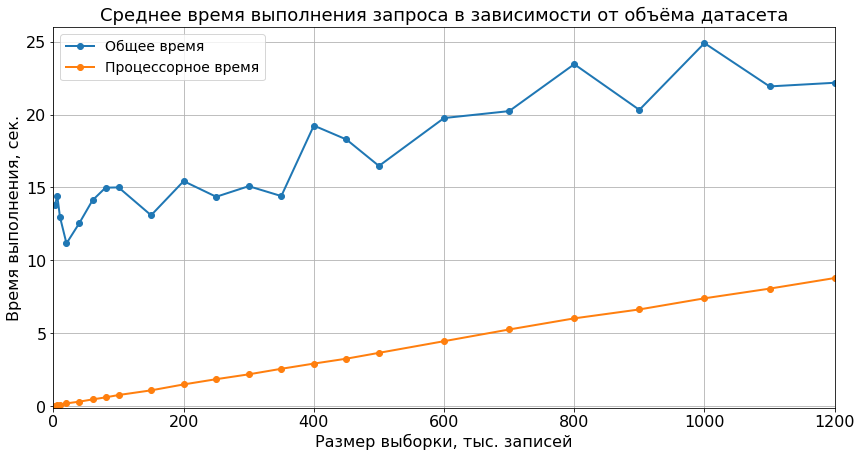

In [16]:
ax = test_df.plot(x='size', figsize=(14, 7), grid=True,
                  xlim=(0,1200), ylim=(-0.1,26),
                  fontsize=16, linewidth=2, style='o-')
ax.set_xlabel('Pазмер выборки, тыс. записей', fontsize=16)
ax.set_ylabel('Время выполнения, сек.', fontsize=16)
ax.set_title("Среднее время выполнения запроса в зависимости от объёма датасета", fontsize=18)
ax.legend(['Общее время', 'Процессорное время'], fontsize=14);

In [ ]:
test_df

#### Тест 0

In [54]:
import time
sizes = []
times = []
sizes.extend(list(range(2000, 10001, 4000)))
sizes.extend(list(range(20_000, 100_000, 20_000)))
sizes.extend(list(range(100_000, 500_000, 50_000)))
sizes.extend(list(range(500_000, 1250_000, 100_000)))
df1 = df.drop('vehicles', axis=1)
iters = 5
for s in sizes:
    t = 0
    for i in range(iters):
        df_ = df1.sample(s)
        begin = time.time()
        df_.sketch.ask('Опиши датасет')
        t += time.time()-begin
    times.append(t/iters)
    print(s, t)
test_df = pd.DataFrame({'size':sizes, 'time':times})
test_df['size'] = test_df['size'] / 1000
test_df

2000 50.68166255950928


6000 63.46045660972595


10000 61.08577799797058


20000 73.62308502197266


40000 57.03283190727234


60000 77.57116794586182


80000 81.95738339424133


100000 78.5295741558075


150000 73.87414264678955


200000 69.47513198852539


250000 88.60846543312073


300000 91.36043810844421


350000 87.61038541793823


400000 97.07733130455017


450000 90.15607571601868


500000 87.05151224136353


600000 105.74999141693115


700000 113.2233498096466


800000 112.25982308387756


900000 118.99462127685547


1000000 120.47132563591003


1100000 118.42129611968994


1200000 125.89042091369629


,size,time
0,2000,10.136333
1,6000,12.692091
2,10000,12.217156
3,20000,14.724617
4,40000,11.406566
5,60000,15.514234
6,80000,16.391477
7,100000,15.705915
8,150000,14.774829
9,200000,13.895026


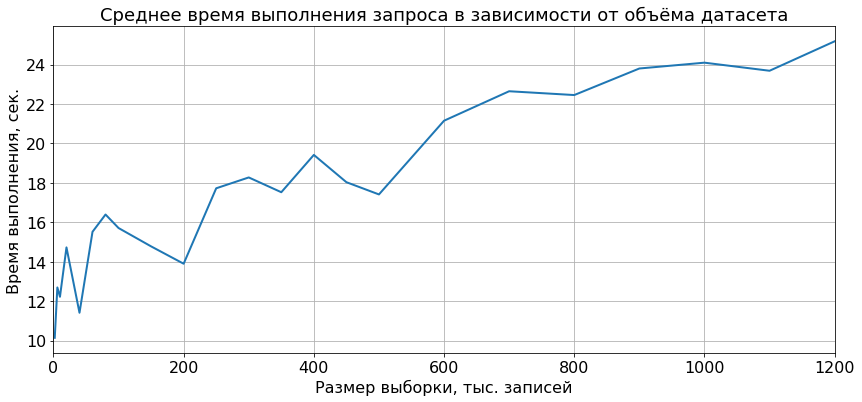

In [ ]:
ax = test_df.plot(x='size', figsize=(14, 6), grid=True, # , y='time'
             fontsize=16, xlim=(0,1200), linewidth=2)   # , legend=False
ax.set_xlabel('Pазмер выборки, тыс. записей', fontsize=16)
ax.set_ylabel('Время выполнения, сек.', fontsize=16)
ax.set_title("Среднее время выполнения запроса в зависимости от объёма датасета", fontsize=18);

In [63]:
df1.parent_region.value_counts()

Москва                          72122
Краснодарский край              52505
Санкт-Петербург                 47860
Московская область              47119
Нижегородская область           41482
                                ...  
Магаданская область              1955
Еврейская автономная область     1803
Республика Ингушетия             1649
Ненецкий автономный округ         253
Чукотский автономный округ        201
Name: parent_region, Length: 85, dtype: int64

In [66]:
df2 = df1[(df1.parent_region=='Москва') | (df1.parent_region=='Московская область')]
times = []
iters = 5
for s in sizes[:8]:
    t = 0
    for i in range(iters):
        df_ = df2.sample(s)
        begin = time.time()
        df_.sketch.ask('Опиши датасет')
        t += time.time()-begin
    times.append(t/iters)
    print(s, t)
test_df2 = pd.DataFrame({'size':sizes[:8], 'time':times})
test_df2['size'] = test_df['size'] / 1000
test_df2

2000 71.42739748954773


6000 83.5719404220581


10000 69.26135873794556


Failed to use remote https://prompts.approx.dev.. ('Connection aborted.', ConnectionResetError(10054, 'Удаленный хост принудительно разорвал существующее подключение', None, 10054, None)). 
Consider setting SKETCH_USE_REMOTE_LAMBDAPROMPT=False 
and run with your own open-ai key



20000 59.05242323875427


40000 76.56100463867188


60000 66.25451040267944


80000 71.07951474189758


100000 72.93494415283203


,size,time
0,2.0,14.285479
1,6.0,16.714388
2,10.0,13.852272
3,20.0,11.810485
4,40.0,15.312201
5,60.0,13.250902
6,80.0,14.215903
7,100.0,14.586989


<AxesSubplot:title={'center':'Среднее время выполнения запроса в зависимости от объёма датасета'}, xlabel='Pазмер выборки, тыс. записей', ylabel='Время выполнения, сек.'>

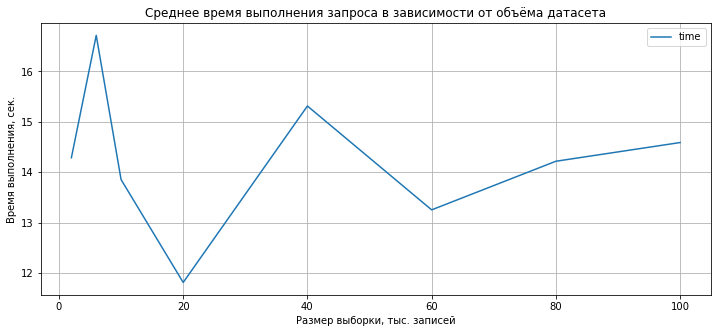

In [86]:
test_df2.plot(x='size', y='time', figsize=(12, 5), grid=True, 
             xlabel='Pазмер выборки, тыс. записей', ylabel='Время выполнения, сек.', 
             title="Среднее время выполнения запроса в зависимости от объёма датасета")

#### Другое

In [106]:
df.parent_region.value_counts()

Москва                          72122
Краснодарский край              52505
Санкт-Петербург                 47860
Московская область              47119
Нижегородская область           41482
                                ...  
Магаданская область              1955
Еврейская автономная область     1803
Республика Ингушетия             1649
Ненецкий автономный округ         253
Чукотский автономный округ        201
Name: parent_region, Length: 85, dtype: int64

In [5]:
df.parent_region.value_counts()

Хабаровский край                14362
Амурская область                 9546
Сахалинская область              5017
Еврейская автономная область     1737
Name: parent_region, dtype: int64

In [107]:
df0[['datetime','parent_region','region','address','lat','lon']].sketch.ask(
    'Как заполнить пропуски в столбце адреса, восстановить улицу и номер дома?')

In [11]:
df.sketch.ask("Какие географические данные есть в датасете?")

In [15]:
df.sketch.ask("Предложи, как переименовать столбцы (результат в html формате)")

In [108]:
df.sketch.ask("Какие уникальные значения у столбцов category, severity?")

In [110]:
df.sketch.ask('Диапазон значений широты')
df.lat.describe()

count     1270607.0
unique     762639.0
top            55.0
freq         3722.0
Name: lat, dtype: float64

In [17]:
cols = ['parent_region','region','category','severity','participant_categories','light','weather']
df.sketch.ask(f"Количество уникальных значений полей {cols} (результат в виде html)")

Column Name,Unique Count
parent_region,4
region,61
category,16
severity,3
participant_categories,21
light,6
weather,24


In [19]:
pd.DataFrame({'Unique Count': [df[col].unique().shape[0] for col in cols]}, index=cols)

,Unique Count
parent_region,4
region,61
category,16
severity,3
participant_categories,21
light,6
weather,24


In [112]:
df.describe()

In [22]:
cols = ['parent_region','severity','light',]
df.sketch.ask(f"Уникальные значения полей {cols}")

In [26]:
{col: df[col].unique().tolist() for col in cols}

{'parent_region': ['Хабаровский край',
  'Еврейская автономная область',
  'Амурская область',
  'Сахалинская область'],
 'severity': ['Легкий', 'Тяжёлый', 'С погибшими'],
 'light': ['Светлое время суток',
  'В темное время суток, освещение отсутствует',
  'В темное время суток, освещение не включено',
  'В темное время суток, освещение включено',
  'Сумерки',
  'Не установлено']}

In [8]:
print(f'Уникальные значения category\n{df.category.unique()}')
print(f'Уникальные значения severity\n{df.severity.unique()}')

Уникальные значения category
['Отбрасывание предмета' 'Столкновение' 'Наезд на стоящее ТС'
 'Наезд на пешехода' 'Опрокидывание' 'Наезд на велосипедиста'
 'Съезд с дороги' 'Иной вид ДТП' 'Наезд на препятствие'
 'Наезд на внезапно возникшее препятствие' 'Падение пассажира'
 'Наезд на животное'
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ'
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность'
 'Падение груза'
 'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы']
Уникальные значения severity
['Легкий' 'Тяжёлый' 'С погибшими']


In [ ]:
df.sketch.ask('Какие минимальные и максимальные, средние и медианные значения у численных столбцов?')

In [ ]:
df.describe()

,lat,lon,participants_count,injured_count,dead_count
count,30662.000000,30662.000000,30662.000000,30662.000000,30662.000000
mean,49.445560,134.289527,2.426424,1.262214,0.104135
std,1.795554,5.275187,1.165527,0.899246,0.368720
min,46.004200,120.166667,1.000000,0.000000,0.000000
25%,48.422789,128.481935,2.000000,1.000000,0.000000
50%,48.971184,135.078009,2.000000,1.000000,0.000000
75%,50.514203,137.004433,3.000000,1.000000,0.000000
max,60.087426,156.143100,58.000000,43.000000,15.000000


#### Ещё некоторые примеры

In [12]:
df.sketch.ask('Как определить долю иномарок среди автомобилей?')

In [14]:
df.sketch.ask("Как визуализировать ДТП на карте?")

In [53]:
df.sketch.ask('Как построить гистограмму количества пострадавших?')

In [54]:
df.sketch.ask("Какие значения и содержатся в столбце light")

In [58]:
df.sketch.ask("Сколько ДТП с участием пешеходов")

In [57]:
df.sketch.ask("Сколько ДТП произошло в тёмное время суток и в светлое время суток?")
df.light.value_counts()

Светлое время суток                            19465
В темное время суток, освещение включено        6362
В темное время суток, освещение отсутствует     3876
Сумерки                                          643
В темное время суток, освещение не включено      313
Не установлено                                     3
Name: light, dtype: int64

In [61]:
df.sketch.ask("Сколько ДТП с пострадавшими?")
df.sketch.ask("Сколько строк со значением `injured_count` больше 0?")
df.sketch.ask("How many rows with `injured_count` greater than 0?")
print('ДТП с пострадавшими:', (df.injured_count > 0).sum())

ДТП с пострадавшими: 28915


In [16]:
df.sketch.ask("Сколько ДТП с умершими?")
print('ДТП с умершими:', (df.dead_count > 0).sum())

ДТП с умершими: 2785


In [18]:
df.sketch.ask("Сколько ДТП с `participants_count` равным 1?")
print('ДТП с одним участником:', (df.participants_count == 1).sum())

ДТП с одним участником: 3303


### `.howto` write the code

#### Генерация признаков

In [ ]:
df.sketch.howto('Сгенерируй новые признаки')

In [ ]:
df.drop('datetime',axis=1).sketch.howto('Сгенерируй новые признаки')

In [ ]:
df.datetime = df.datetime.astype(str)
df.sketch.howto('Сгенерируй новые признаки')

In [ ]:
df.sketch.howto('Сгенерируй новые признаки (поле datetime необходимо перевести из строки в datetime64)')

In [ ]:
print(df.weather.unique())

['Ясно' 'Дождь' 'Пасмурно' 'Снегопад' 'Метель' 'Пасмурно, Дождь'
 'Ясно, Туман' 'Пасмурно, Снегопад' 'Снегопад, Метель' 'Дождь, Снегопад'
 'Туман' 'Дождь, Ураганный ветер' 'Туман, Температура ниже -30С'
 'Пасмурно, Туман' 'Ясно, Температура ниже -30С' 'Дождь, Туман'
 'Снегопад, Температура ниже -30С' 'Пасмурно, Температура ниже -30С'
 'Ясно, Дождь' 'Ясно, Температура выше +30С' 'Пасмурно, Метель'
 'Пасмурно, Ураганный ветер' 'Пасмурно, Температура выше +30С'
 'Метель, Ураганный ветер']


In [ ]:
df.sketch.howto('Сгенерируй новые логические признаки из всех возможных погодных условий в поле `weather` (сначала приведи значения к нижнему регистру)')

In [ ]:
df.sketch.howto('Сгенерируй новые логические признаки из всех возможных погодных условий в поле `weather` (погодные условия перечисляются через запятую)')

In [ ]:
df1 = df.copy()
# Create a list of all possible weather conditions
weather_conditions = df['weather'].str.split(', ').tolist()
weather_conditions = [item for sublist in weather_conditions for item in sublist]
weather_conditions = list(set(weather_conditions))

# Create new boolean columns for each weather condition
for condition in weather_conditions:
    df1[condition] = df['weather'].str.contains(condition).astype(int)
    
df1[weather_conditions].sample(5)

,Температура выше +30С,Ясно,Дождь,Температура ниже -30С,Пасмурно,Снегопад,Туман,Метель,Ураганный ветер
11106,0,0,0,0,1,0,0,0,0
4025,0,1,0,0,0,0,0,0,0
25534,0,0,0,0,0,1,0,0,0
24867,0,1,0,0,0,0,0,0,0
22514,0,1,0,0,0,0,0,0,0


#### Манипуляции с данными

In [75]:
df.vehicles.sample(5)

150                           [None None None]
29443                      [TOYOTA Vista 1990]
2725                         [HONDA Logo 1999]
25595    [NISSAN Juke 1994, NISSAN Tiida 2009]
6093      [TOYOTA Crown 2002, YAMAHA XVS 2003]
Name: vehicles, dtype: object

In [63]:
df.sketch.ask('Какой минимальный и максимальный годы выпуска автомобилей (колонка vehicles имеет тип списка, год может быть неизвестен)?')

In [80]:
df.sketch.howto('Определи минимальный и максимальный годы выпуска автомобилей (колонка vehicles имеет тип списка, год может быть неизвестен)?')

In [ ]:
# Get list of all vehicles
vehicles_list = df['vehicles'].tolist()

# Create empty list to store all years
years_list = []

# Iterate through the list of vehicles and extract the year from each vehicle
for vehicles in vehicles_list:
    for v in vehicles:
        # Split the string on space to get the year
        year = v.split(' ')[-1]
        # Append the year to the list of years
        if year.isdigit():
            years_list.append(int(year))
        
# Calculate min and max years from the list of years
min_year = min(years_list)
max_year = max(years_list)

print('Min Year:', min_year)
print('Max Year:', max_year)

Min Year: 1
Max Year: 2022


In [91]:
df.sketch.howto("""
    Посчитать количество ДТП с участием машин марки `TOYOTA` до 2000 года выпуска,
    поле `vehicles` имеет тип списка, год может быть неизвестен
""")

In [93]:
# Count the number of accidents involving Toyota vehicles before 2000
toyota_before_2000 = df[df['vehicles'].apply(lambda x: any('TOYOTA' in v and (int(v.split()[-1]) < 2000 if v.split()[-1].isdigit() else False) for v in x))].shape[0]
print(f'Number of accidents involving Toyota vehicles before 2000: {toyota_before_2000}')

Number of accidents involving Toyota vehicles before 2000: 8961


In [97]:
df.sketch.howto("""
    Количество ДТП с участием машин марки `TOYOTA` до 2000 года выпуска,
    поле `vehicles` имеет тип списка, год может быть неизвестен
""")

In [98]:
df.sketch.howto('Количество ДТП с участием мотоциклистов')

In [111]:
# Count the number of accidents involving motorcyclists
motorcycle_accidents = df[df['participant_categories'].str.contains('Мотоциклисты')].shape[0]
print(f'Number of accidents involving motorcyclists: {motorcycle_accidents}')

Number of accidents involving motorcyclists: 2221


In [15]:
df.sketch.howto('Какая фаза луны была в день ДТП?')

In [17]:
df.sketch.howto('На каком расстоянии от Москвы произошло ДТП?')

In [112]:
# import necessary libraries
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# define coordinates of Moscow
moscow_lat = 55.755826
moscow_lon = 37.6173

# calculate distance from Moscow for each row in the dataframe
df['distance_from_moscow'] = df.apply(lambda row: geodesic((row['lat'], row['lon']), (moscow_lat, moscow_lon)).km, axis=1)

# print the min and max distances from Moscow
print('Minimum distance from Moscow:', df['distance_from_moscow'].min())
print('Maximum distance from Moscow:', df['distance_from_moscow'].max())

Minimum distance from Moscow: 4737.977084020733
Maximum distance from Moscow: 7127.686149630483


In [110]:
df.sketch.howto('Сколько ДТП произошли в день рождения Ленина?')

In [102]:
df.sketch.ask('День рождения Ленина')

In [103]:
df.sketch.howto('День рождения Ленина')

#### Графики

In [121]:
df.sketch.howto("""Построить гистограмму количества пострадавших, 
                установить количество корзин равным максимальному значению""")

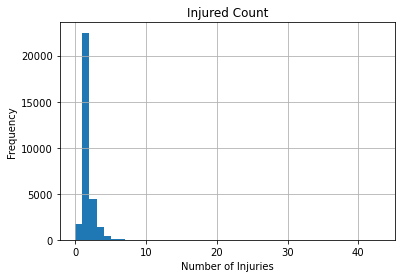

In [5]:
import matplotlib.pyplot as plt

# Get the max value of injured_count
max_injured_count = df['injured_count'].max()

# Create a histogram of the injured_count column with max_injured_count bins
df['injured_count'].hist(bins=max_injured_count)

# Set the title and labels for the histogram
plt.title('Injured Count')
plt.xlabel('Number of Injuries')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [13]:
df.drop('vehicles',axis=1).sketch.howto("""Построй координаты на графике с помощью seaborn 
    Цветом обозначь разные `parent_region`, 
    размер графика 12 на 9, размер точек пропорционально `participants_count`,
    подпиши названия осей и графика, добавь на график сетку,
    прозрачность точек 30 процентов""")

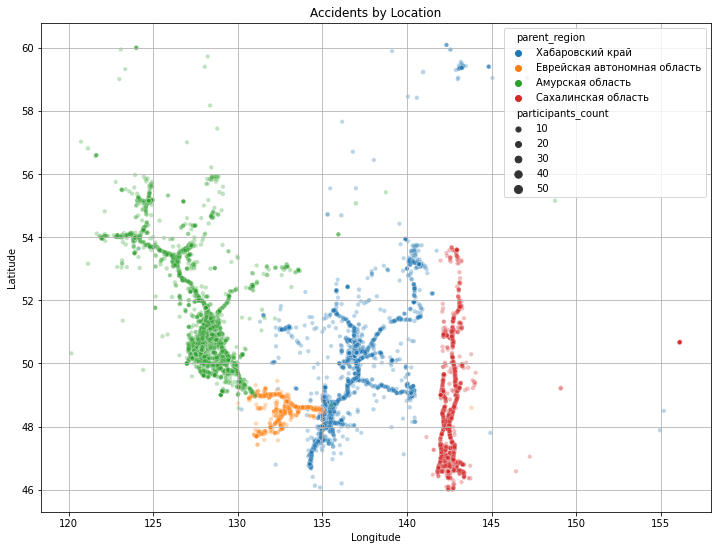

In [14]:
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 9))

# Plot the data
sns.scatterplot(x="lon", y="lat", hue="parent_region", size="participants_count", data=df, alpha=0.3)

# Add labels and grid
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accidents by Location')
plt.grid(True)

Text(0, 0.5, 'Latitude')

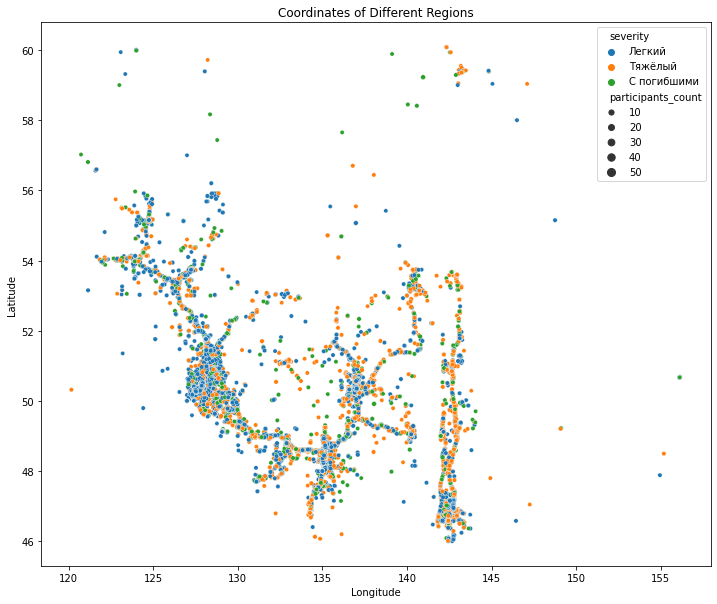

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 10))

# Plot the data
sns.scatterplot(x="lon", y="lat", hue="severity", size="participants_count", data=df)

# Add labels and title
plt.title("Coordinates of Different Regions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [15]:
df.sketch.howto('Кластеризация точек')

In [17]:
df.sketch.howto("""Построить модель, 
    предсказывающую количество погибших в ДТП на основе численных признаков""")

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#separate the dataframe into features and target variables
X = df[['lat', 'lon', 'participants_count', 'injured_count']]
y = df['dead_count']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit the model to the training data
model = LinearRegression()
model.fit(X_train, y_train)

#make predictions on the test data
y_pred = model.predict(X_test)

#evaluate the model's performance using metrics such as mean squared error and r2 score
mse = mean_squared_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred) 
print('Mean Squared Error:', mse) 
print('R2 Score:', r2) 